In [16]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null, forward_simulation

### Load data

In [17]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'ryan'
category = 'natural'
eccentricity = 'periphery'
movie_id = 6
diameter = 36; # 6, 24, 36
dat_movie_name = 'DAM'   # movie name as in the data file name
stim_movie_name = 'carnegie-dam' # movie name as in the stimulus file name
n_bootstraps = 1

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [18]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [19]:
is_natural = True if category == 'natural' else False
    
n_dim = n_frames - 1
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_dim=n_dim, n_starts=10, n_iter=10000, n_frames=n_frames, is_natural=is_natural, version=1, disp=False)

Current loss: 554.0721197500825
Loss updated
Iteration 1 | Loss: 554.0721197500825
Current loss: 550.055039703846
Loss updated
Iteration 2 | Loss: 550.055039703846
Current loss: 607.0531599670649
Iteration 3 | Loss: 607.0531599670649
Current loss: 615.7493939325213
Iteration 4 | Loss: 615.7493939325213
Current loss: 583.1893813982606
Iteration 5 | Loss: 583.1893813982606
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 6 | Loss: 587.8260247558355
Current loss: 573.1260549202561
Iteration 7 | Loss: 573.1260549202561
Current loss: 585.2067164778709
Iteration 8 | Loss: 585.2067164778709
Current loss: 559.3659459501505
Iteration 9 | Loss: 559.3659459501505
Current loss: 561.9705793038011
Iteration 10 | Loss: 561.9705793038011


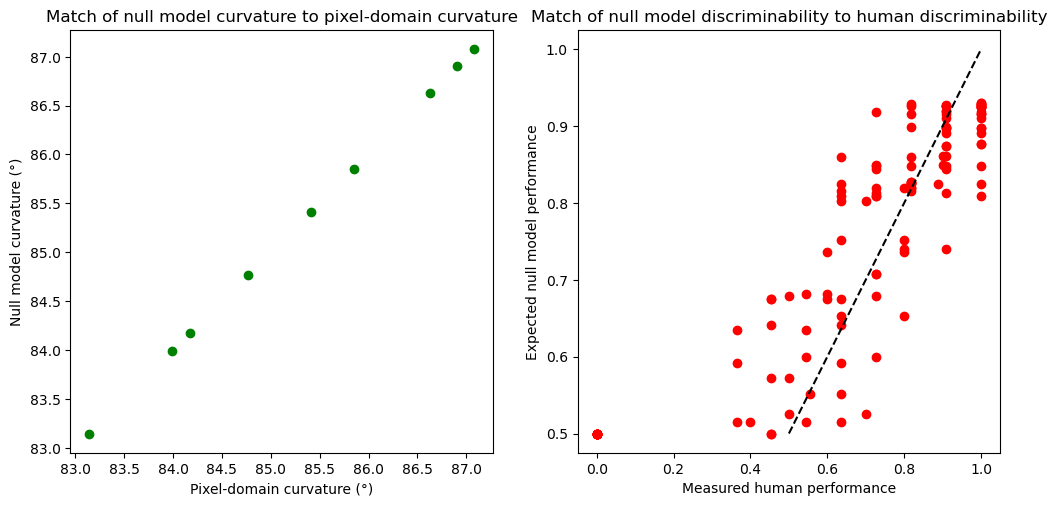

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Measured human performance')
axs[1].set_ylabel('Expected null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [21]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.squeeze(), n_reps)

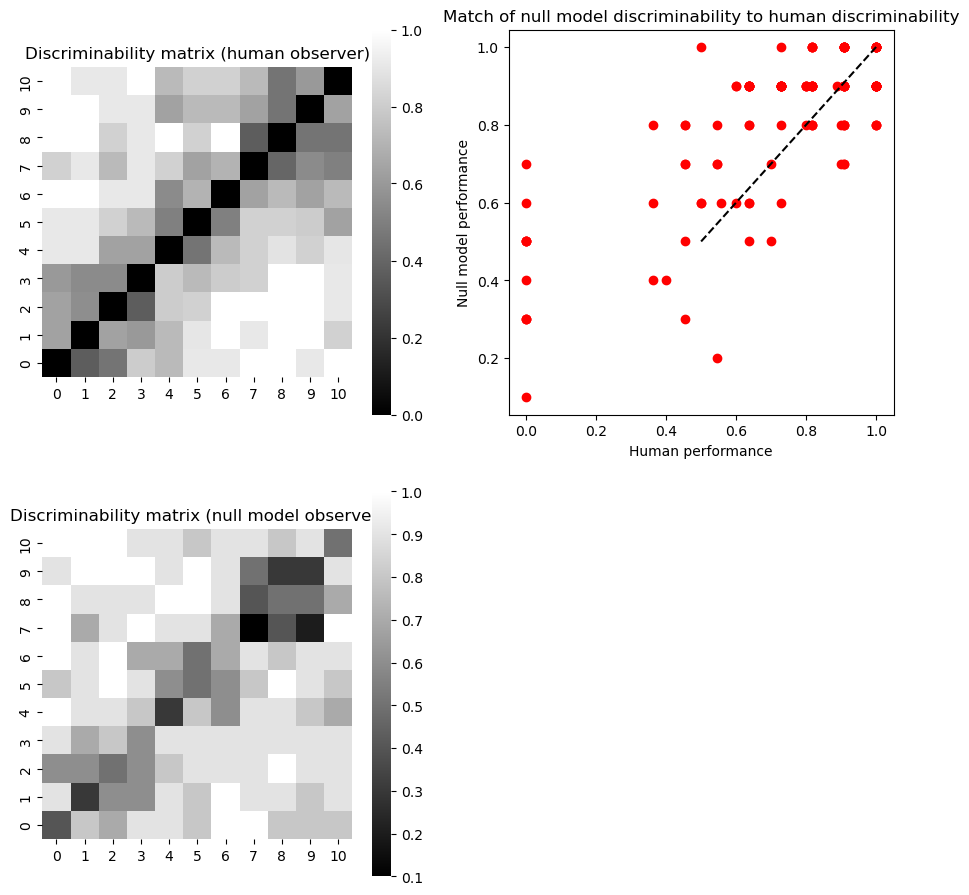

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on simulated data from null model

In [23]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=80000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, _, _, _, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 421.78732197731733
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 2 | Loss: 414.98834128677845
Current loss: 406.4147652387619
Loss updated
Iteration 3 | Loss: 406.4147652387619
Current loss: 409.3423503488302
Iteration 4 | Loss: 409.3423503488302
Current loss: 429.57507741451263
Iteration 5 | Loss: 429.57507741451263
Current loss: 408.8653955459595
Iteration 6 | Loss: 408.8653955459595
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 7 | Loss: 425.3688490986824
Current loss: 409.3489146903157
Iteration 8 | Loss: 409.3489146903157
Current loss: 406.7828939780593
Iteration 9 | Loss: 406.7828939780593
Current loss: 422.2669020444155
Iteration 10 | Loss: 422.2669020444155
Epoch: 0, Loss: 6067.171309876497
Epoch: 250, Loss: 2630.3984116288602
Epoch: 500, Loss: 1879.3457633956732
Epoch: 750, Loss: 1529.767656808919
Epoch: 1000, Loss: 1319.1132097045224
Epoch: 1250, Loss: 1175.078422344372
Epoc

In [24]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 97.24876403808594 degrees
Average estimated local curvature: 97.24900044280555 degrees


### Run optimization on real data

In [25]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 559.3727379590273
Loss updated
Iteration 1 | Loss: 559.3727379590273
Current loss: 566.5197166278958
Iteration 2 | Loss: 566.5197166278958
Current loss: 570.3092503398657
Iteration 3 | Loss: 570.3092503398657
Current loss: 560.1061358079314
Iteration 4 | Loss: 560.1061358079314
Current loss: 565.4665566757321
Iteration 5 | Loss: 565.4665566757321
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 6 | Loss: 578.103216893971
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 7 | Loss: 563.0742804855108
Current loss: 554.5555327162147
Loss updated
Iteration 8 | Loss: 554.5555327162147
Current loss: 561.4412784352899
Iteration 9 | Loss: 561.4412784352899
Current loss: 559.3211034610868
Iteration 10 | Loss: 559.3211034610868
Epoch: 0, Loss: 3436.29510702147
Epoch: 250, Loss: 2132.412079921639
Epoch: 500, Loss: 1677.5359846383628
Epoch: 750, Loss: 1429.6352683253353
Epoch: 1000, Loss: 1276.879837703733
Epoch: 1250, Loss: 1170.0267809659

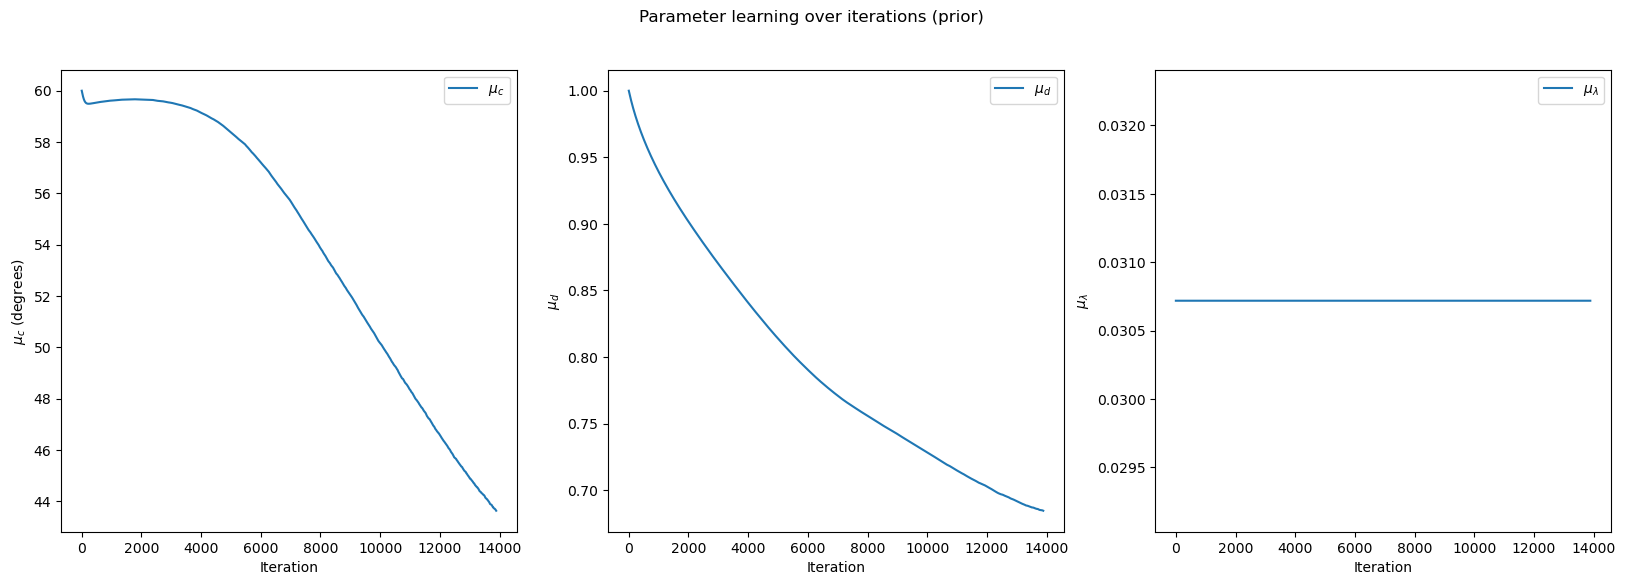

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

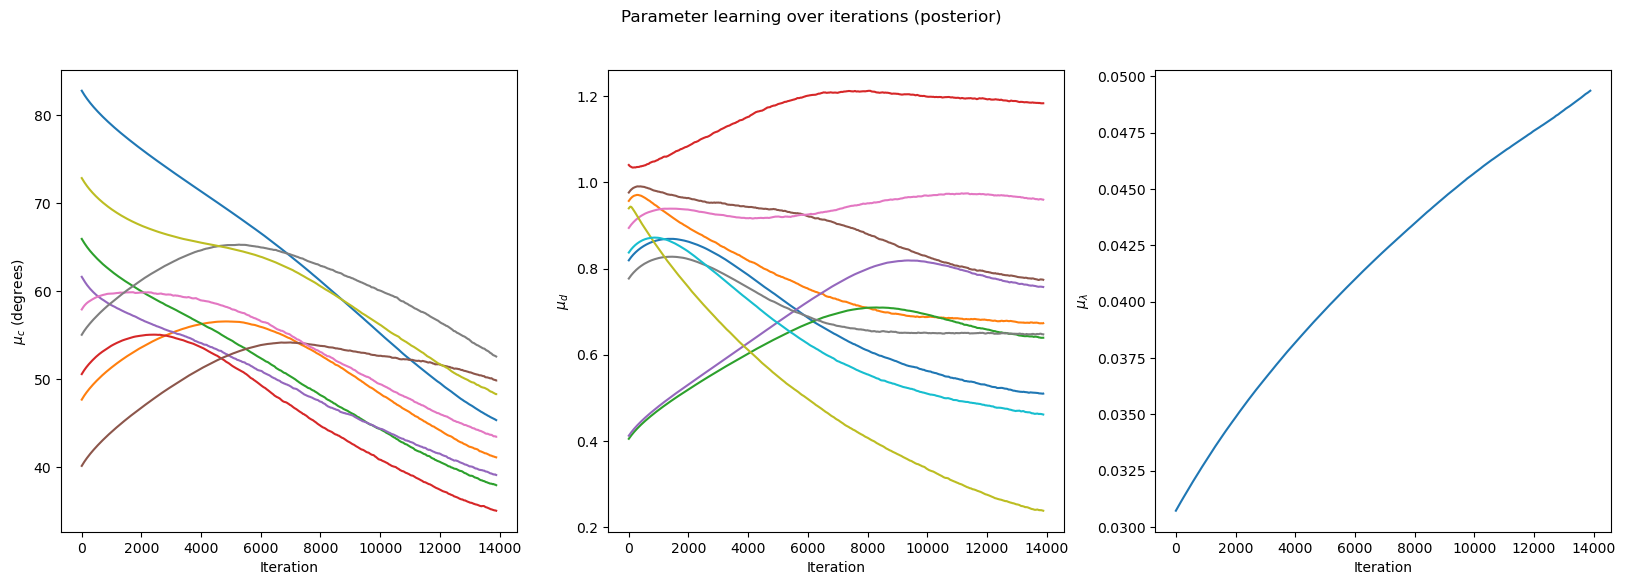

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [28]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 43.63773727416992 degrees
Average estimated local curvature: 43.63872583338597 degrees


### Analyze results

In [29]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

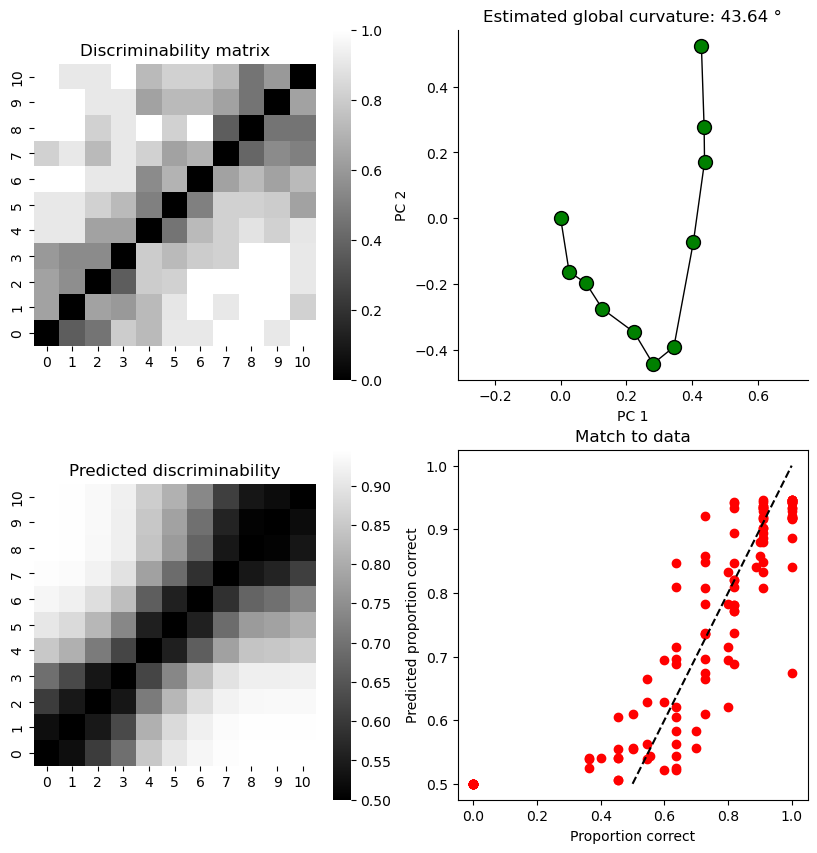

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()